# Analyse Spatial Patterns in Classifications

In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import seaborn as sns

### Get gentrification scores

In [2]:
city='melbourne'
central_suburbs = gpd.read_file(f"../../../data/SpatialData/MelbourneSuburbs.shp")

In [3]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
gentrification_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_combined_listings_filtered_02.csv')

In [4]:
gentrification_df['geometry'] = gentrification_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gentrification_gdf = gpd.GeoDataFrame(gentrification_df, geometry='geometry', crs="EPSG:4326")

In [5]:
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
gentrification_gdf['gentrification_prediction_code'] = gentrification_gdf['gentrification_prediction'].map(mapping)

In [13]:
central_suburbs = central_suburbs.merge(gentrification_gdf, on='SAL_NAME21', how='left')
central_suburbs

KeyError: 'SAL_NAME21'

### Get summary score for each suburb

In [6]:
suburb_scores_gentrification = gentrification_gdf.groupby("SAL_NAME21")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0])
suburb_scores_gentrification_df = pd.DataFrame(suburb_scores_gentrification)
suburb_scores_gentrification_df.reset_index(inplace=True)

suburb_counts_gentrification = gentrification_gdf.groupby("SAL_NAME21")["gentrification_prediction_code"].count()
suburb_counts_gentrification_df = pd.DataFrame({'count': suburb_counts_gentrification})
suburb_counts_gentrification_df.reset_index(inplace=True)

suburb_scores_gentrification_df = suburb_scores_gentrification_df.merge(suburb_counts_gentrification_df, on='SAL_NAME21', how='outer')

KeyError: 'SAL_NAME21'

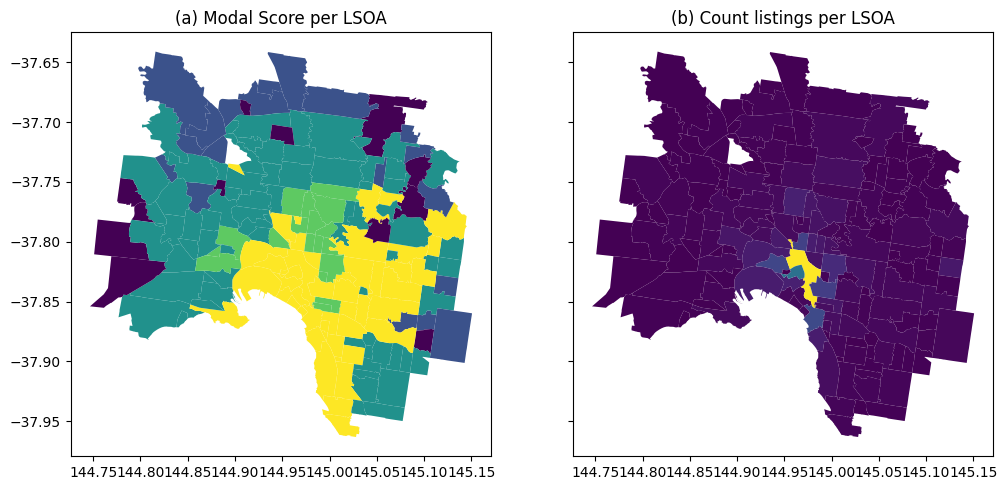

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]}, sharey=True, sharex=True)  # Ensure equal subplot sizes
central_suburbs.plot('gentrification_prediction_code', ax=axs[0])
axs[0].set_title("(a) Modal Score per LSOA")
central_suburbs.plot('count', ax=axs[1]);
axs[1].set_title("(b) Count listings per LSOA");
plt.tight_layout()
fig.subplots_adjust(wspace=-0.2)

## Cross tabulation: comparison to Gentrification Index

In [10]:
index = pd.read_csv(f"../../../data/GentrificationIndex/MelbourneIndex/Edited.csv")
scores_and_index = suburb_scores_gentrification_df.merge(index, on='SAL_NAME21', how='left')

In [11]:
gentrification_gdf = gentrification_gdf.merge(
    index[['SAL_NAME21', 'Classification']],
    on='SAL_NAME21',
    how='left' )
per_listing = gentrification_gdf[['Classification', 'gentrification_prediction_code']]

### Drop the NA scores for the LLM cats

In [12]:
# scores_and_index = scores_and_index[scores_and_index['gentrification_prediction_code']!=0]

In [13]:
per_listing = per_listing[~per_listing['Classification'].isin([5, 2, 7])]
scores_and_index= scores_and_index[~scores_and_index['Classification'].isin([5, 2, 7])]

In [14]:
scores_and_index['Classification'].min()

np.float64(1.0)

In [15]:
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
mapping_idx = {'Low-Income/Susceptible to Displacement': 1,'Ongoing Displacement': 2, 'At Risk of Gentrification': 3, 
           'Early/Ongoing Gentrification': 4, 'Stable Moderate/Mixed Income':5,
          'At Risk of Becoming Exclusive':6, 'Becoming Exclusive':7, 'Stable/Advanced Exclusive':8}

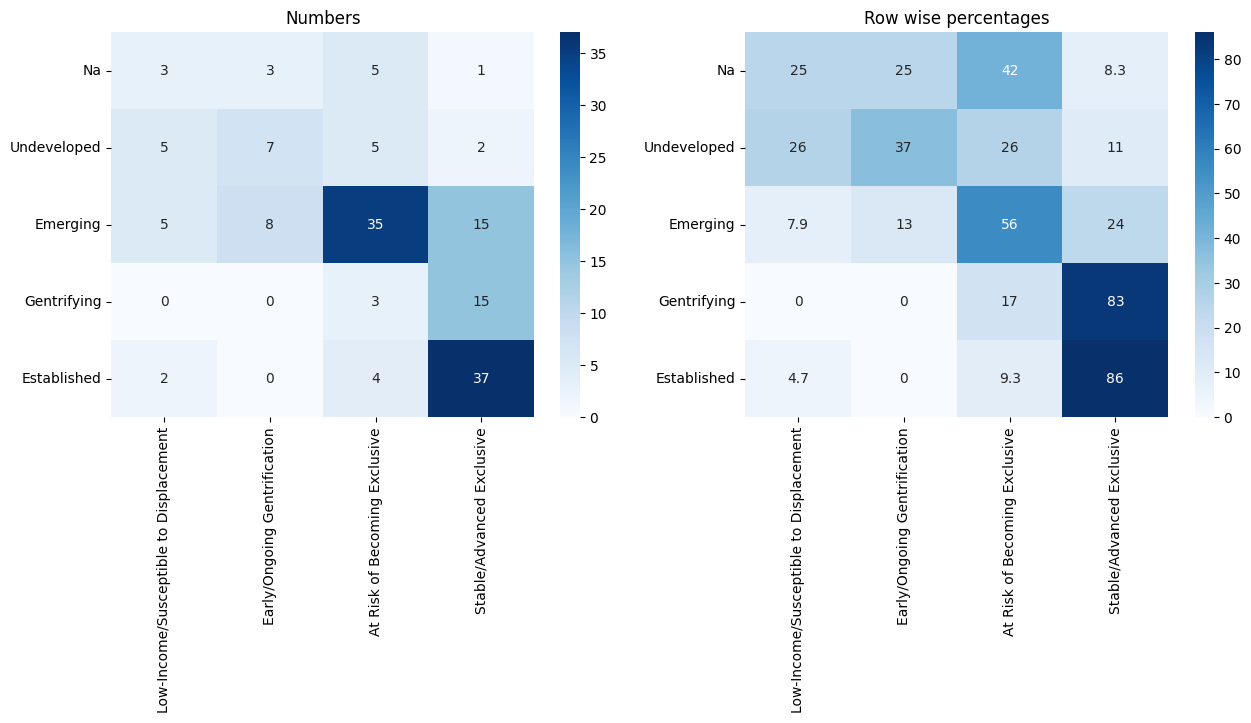

In [26]:
crosstab = pd.crosstab(scores_and_index['gentrification_prediction_code'], scores_and_index['Classification'])

inv_mapping = {v: k for k, v in mapping.items()}
inv_mapping_idx = {v: k for k, v in mapping_idx.items()}
crosstab.rename(index=inv_mapping, columns=inv_mapping_idx, inplace=True)
crosstab_row_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

fig,axs=plt.subplots(ncols=2, figsize=(15,5))
sns.heatmap(crosstab, ax=axs[0], annot=True, cmap='Blues')
axs[0].set_title("Numbers")
axs[0].set_xlabel("")
axs[0].set_ylabel("")
sns.heatmap(crosstab_row_pct, ax=axs[1], annot=True, cmap='Blues')
axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[1].set_title("Row wise percentages");

# plt.figure(figsize=(8, 6))
# sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
# plt.title('Cross-tabulation Heatmap: classification1 vs classification2')
# plt.xlabel('Existing index code')
# plt.ylabel('LLM code')
# plt.show()

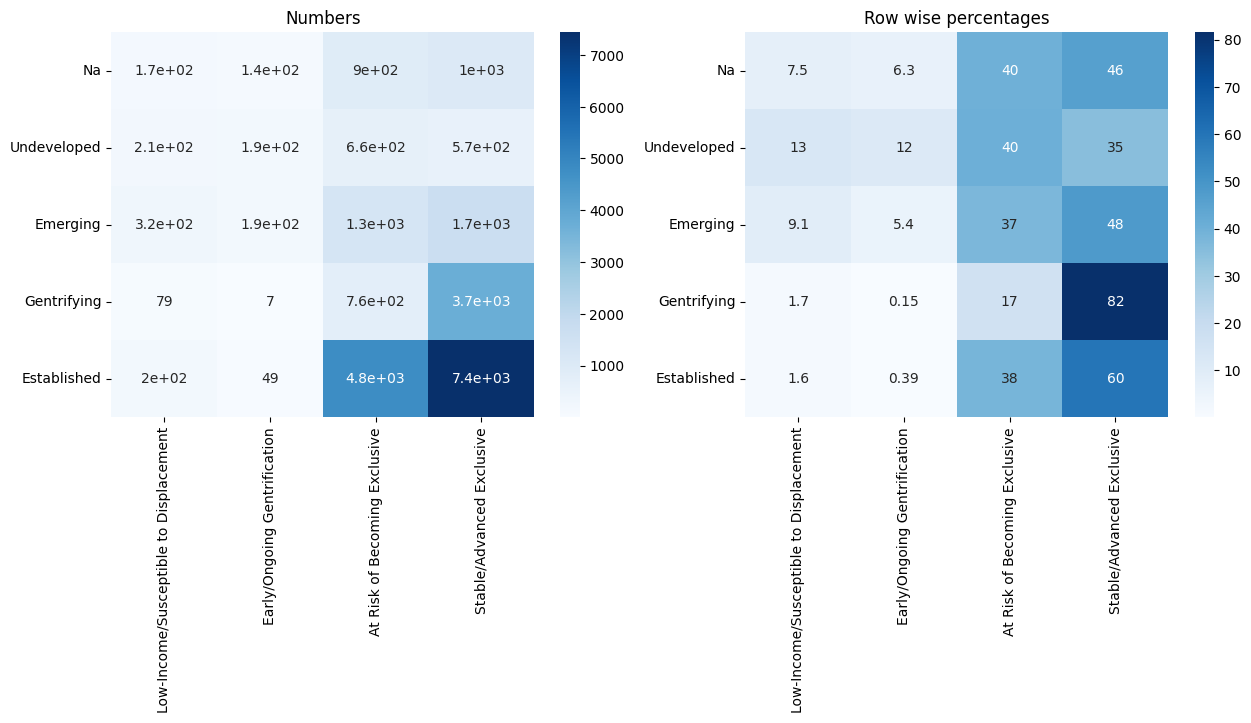

In [16]:
crosstab = pd.crosstab(per_listing['gentrification_prediction_code'], per_listing['Classification'])

inv_mapping = {v: k for k, v in mapping.items()}
inv_mapping_idx = {v: k for k, v in mapping_idx.items()}
crosstab.rename(index=inv_mapping, columns=inv_mapping_idx, inplace=True)
crosstab_row_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

fig,axs=plt.subplots(ncols=2, figsize=(15,5))
sns.heatmap(crosstab, ax=axs[0], annot=True, cmap='Blues')
axs[0].set_title("Numbers")
axs[0].set_xlabel("")
axs[0].set_ylabel("")
sns.heatmap(crosstab_row_pct, ax=axs[1], annot=True, cmap='Blues')
axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[1].set_title("Row wise percentages");

# plt.figure(figsize=(8, 6))
# sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
# plt.title('Cross-tabulation Heatmap: classification1 vs classification2')
# plt.xlabel('Existing index code')
# plt.ylabel('LLM code')
# plt.show()

### Normalised to show the percentage of values in that row in each column

In [20]:
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Cross-tabulation
crosstab = pd.crosstab(scores_and_index['gentrification_prediction_code'], scores_and_index['Classification'])

# Optional: ensure square structure
all_classes = sorted(set(scores_and_index['gentrification_prediction_code']) |
                     set(scores_and_index['Classification']))
# crosstab = crosstab.reindex(index=all_classes, columns=all_classes, fill_value=0)


In [21]:
chi2, p, dof, expected = chi2_contingency(crosstab) 
# Pearson residuals = (observed - expected) / sqrt(expected)
residuals = (crosstab - expected) / (expected ** 0.5)

In [22]:
# Convert to dict with tuple keys: (LLM, Index)
mosaic_data = {
    (str(int(i)), str(int(j))): crosstab.loc[i, j]
    for i in crosstab.index
    for j in crosstab.columns
}

# Color mapping based on residuals
def props(key):
    i, j = int(key[0]), int(key[1])
    r = residuals.loc[i, j]
    # blue for positive residuals, red for negative, white ~ no deviation
    if r > 1.96:
        return {'color': '#2166ac'}  # strong positive
    elif r < -1.96:
        return {'color': '#b2182b'}  # strong negative
    else:
        return {'color': '#f7f7f7'}  # not significant


In [23]:
# Suppose these are all possible categories (adjust as needed)
all_predictions = per_listing['gentrification_prediction_code'].unique()
all_classifications = all_classifications = np.arange(1, 9) 

# Create full cartesian product of all pairs
full_index = pd.MultiIndex.from_product(
    [all_predictions, all_classifications],
    names=['gentrification_prediction_code', 'Classification']
)

# Group and count as you did
mosaic_df = (
    per_listing
    .groupby(['gentrification_prediction_code', 'Classification'])
    .size()
    .reindex(full_index, fill_value=0)  # fill missing pairs with 0 count
    .reset_index(name='count')
)
# Rename columns
mosaic_df.columns = ['Prediction', 'Classification', 'count']
mosaic_df = mosaic_df.sort_values((['Prediction', 'Classification']))

# Then pivot, etc.
table = mosaic_df.pivot_table(index='Prediction', columns='Classification', values='count', aggfunc='sum', fill_value=0)
table

Classification    1  2  3    4  5     6  7     8
Prediction                                      
0.0             170  0  0  141  0   900  0  1042
1.0             212  0  0  189  0   659  0   569
2.0             315  0  0  188  0  1299  0  1669
3.0              79  0  0    7  0   755  0  3729
4.0             199  0  0   49  0  4780  0  7442

In [24]:
import matplotlib.patches as mpatches
from statsmodels.graphics.mosaicplot import mosaic

# Define a color for each classification column
classification_colors = {
    '1': '#d73027',
    '2': '#fc8d59',
    '3': '#fee08b',
    '4': '#d9ef8b',
    '5': '#91cf60',
    '6': '#1a9850',
    '7': '#4575b4',
    '8': '#313695'
}
def props(key):
    classification = str(key[1])  # column key
    color = classification_colors.get(classification, '#f0f0f0')  # fallback color
    return {'color': color}


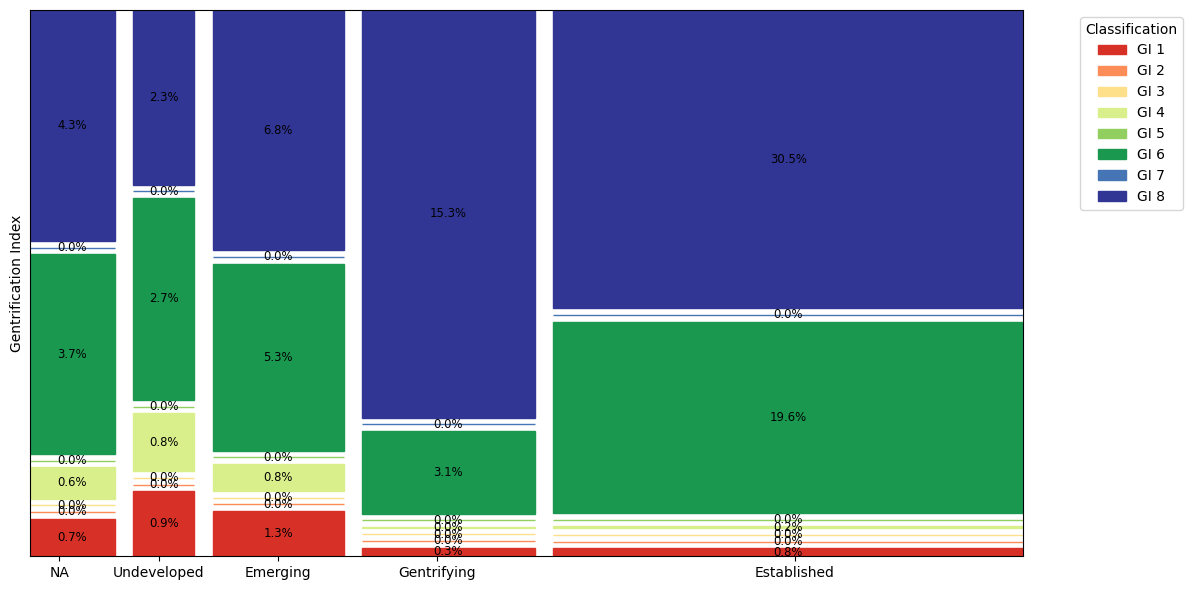

In [25]:
mosaic_data = {
    (str(row), str(col)): table.loc[row, col]
    for row in table.index
    for col in table.columns}

# Total for percent labels
total = sum(mosaic_data.values())

# Label function
def labelizer(key):
    pct = mosaic_data[key] / total * 100
    return f"{pct:.1f}%"

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
mosaic(
    mosaic_data,
    labelizer=labelizer,
    gap=0.02, axes_label=False, properties=props, ax=ax)

legend_patches = [
    mpatches.Patch(color=color, label=f'GI {cls}')
    for cls, color in classification_colors.items()]

plt.legend(
    handles=legend_patches,
    title='Classification',
    bbox_to_anchor=(1.05, 1),
    loc='upper left')

# Extract x/y categories from data
x_labels = mosaic_df['Prediction'].unique()
x_labels = ['NA', 'Undeveloped', 'Emerging', 'Gentrifying', 'Established']
y_labels = mosaic_df['Classification'].unique()

# Set axis ticks manually (adjust positions if necessary)
# ax.set_xticks([i / len(x_labels) + 0.5 / len(x_labels) for i in range(len(x_labels))])
ax.set_xticks([0.03,0.13,0.25,0.41,0.77])
ax.set_xticklabels(x_labels, rotation=0)
# ax.set_yticks([i / len(y_labels) + 0.5 / len(y_labels) for i in range(len(y_labels))])
# ax.set_yticklabels(y_labels)

# Add axis titles
# ax.set_xlabel('Classification from LLM')
ax.set_ylabel('Gentrification Index')

plt.tight_layout()
plt.show()
